In [5]:
%load_ext autoreload
%autoreload 2

import os
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

local_modules_path = [os.getcwd() + '/shared_modules', os.getcwd() + '/VFI_modules']
for path in local_modules_path:
    sys.path.append(path)

import load_and_dump
import plot_funcs

device = "cuda:0" if torch.cuda.is_available() else "cpu"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load Value Function Iteration files

In [6]:
vfi_policy_grid = load_and_dump.load_arrays('/results/arrays/vfi_policy.npy', get_cwd=True)
vfi_time = load_and_dump.load_arrays('/results/arrays/vfi_comp_time.npy', get_cwd=True)
vfi_sim_action = load_and_dump.load_arrays('/results/arrays/vfi_sim_action.npy', get_cwd=True)
vfi_sim_state = load_and_dump.load_arrays('/results/arrays/vfi_sim_state.npy', get_cwd=True)
vfi_sim_obj = load_and_dump.load_arrays('/results/arrays/vfi_sim_obj.npy', get_cwd=True)
vfi_sim_ee = load_and_dump.load_arrays('/results/arrays/vfi_euler_errors.npy', get_cwd=True)

## DeepExplore baseline vs. VFI (low lr = 0.00001)

### Time vs Precision plot

In [17]:
# Import data
de_baseline_low_lr_nn = load_and_dump.load_nn('neuron_450_450', np.array([450, 450]))
de_baseline_low_lr_ee = load_and_dump.load_arrays('/results/tensors/de_baseline_low_lr_ee.pt', tensor=True, get_cwd=True)
de_baseline_low_lr_OSL = load_and_dump.load_arrays('/results/tensors/neuron_450_450_OSL.pt', tensor=True, get_cwd=True)
de_baseline_low_lr_time = load_and_dump.load_arrays('/results/tensors/neuron_450_450_time.pt', tensor=True, get_cwd=True)

de_baseline_low_lr_sim_state = load_and_dump.load_arrays('/results/tensors/de_baseline_low_lr_sim_state.pt', tensor=True, get_cwd=True)
de_baseline_low_lr_sim_action = load_and_dump.load_arrays('/results/tensors/de_baseline_low_lr_sim_action.pt', tensor=True, get_cwd=True)
de_baseline_low_lr_sim_obj = load_and_dump.load_arrays('/results/tensors/de_baseline_low_lr_sim_obj.pt', tensor=True, get_cwd=True)

/Users/mikkelrich/Desktop/Final files/shared_modules/load_and_dump.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(array_path)


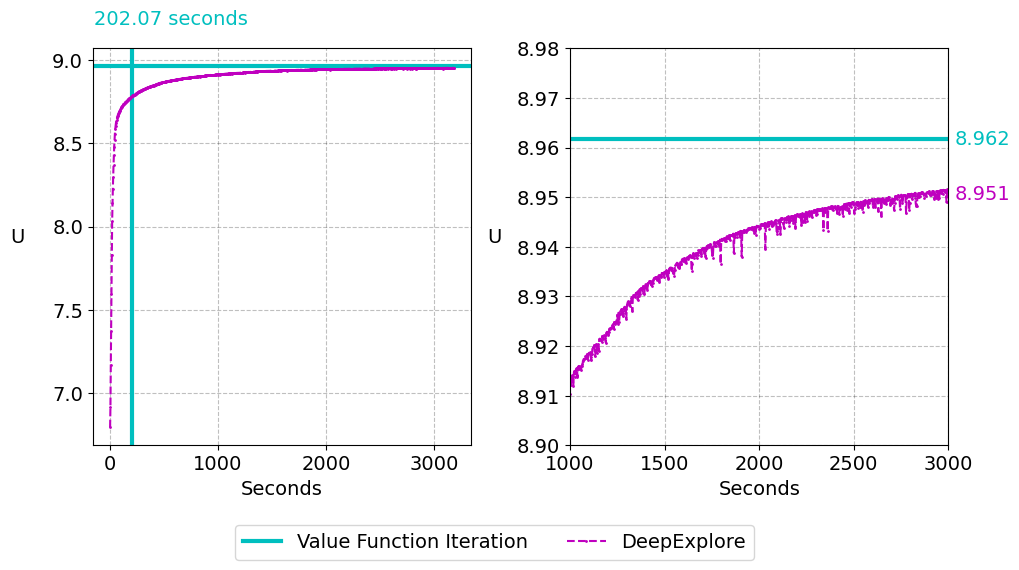

In [18]:
de_y = (-de_baseline_low_lr_OSL).tolist()
de_x = torch.cumsum(de_baseline_low_lr_time[:, -1], dim=0).tolist()

f, ax = plt.subplots(1,2, figsize=(10, 5))

# 1st plot
ax[0].axvline(x=vfi_time.sum(), label='Value Function Iteration', color='c', linewidth=3)
ax[0].axhline(y=vfi_sim_obj.mean(), color='c', linewidth=3)
ax[0].set_xlabel('Seconds')

ax[0].plot(de_x, de_y, linestyle='--', marker='o', markersize=1, color='m', label='DeepExplore')
ax[0].set_ylabel('U', rotation=0)
ax[0].yaxis.set_label_coords(-0.2, 0.5)

# 2nd plot
ax[1].axvline(vfi_time.sum(), color='c', linewidth=3)
ax[1].axhline(vfi_sim_obj.mean(), color='c', linewidth=3)
ax[1].set_xlabel('Seconds')
ax[1].plot(de_x, de_y, linestyle='--', marker='o', markersize=1, color='m')

ax[1].set_ylabel('U', rotation=0)
ax[1].yaxis.set_label_coords(-0.2, 0.5)
ax[1].set_xlim([1000,3000])
ax[1].set_ylim([8.9, 8.98])

# Add text
f.text(0.1, 0.99, f'{vfi_time.sum():.2f} seconds', color='c')
f.text(0.96, 0.75, f'{vfi_sim_obj.mean():.3f}', color='c')
f.text(0.96, 0.64, f'{de_y[-1]:.3f}', color='m')

# Make pretty
f.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2)
f.tight_layout()

#plt.savefig('VFI_vs_DE_baseline_low_lr_time_vs_precision.png')

### Policy, action, state plot

<>:24: SyntaxWarning: invalid escape sequence '\p'
<>:24: SyntaxWarning: invalid escape sequence '\p'
/var/folders/33/xqtwrk8s3ws6yhnm9qx48q2m0000gn/T/ipykernel_6495/422451058.py:24: SyntaxWarning: invalid escape sequence '\p'
  ax[0].set_ylabel(f'$\pi_{{{period}}}$', rotation=0)


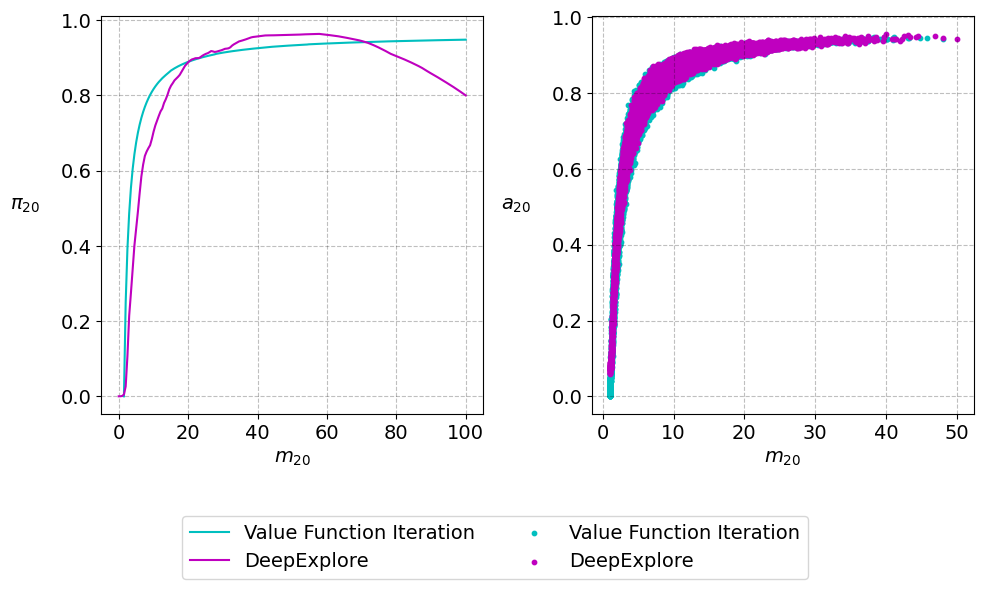

In [20]:
# Choose period
period = 20

# Extract policy function and policy network
vfi_m_grid = np.linspace(0, 100, 200)
vfi_R_grid = np.linspace(0.5, 1.5, 200)
vfi_p_grid = np.linspace(0, 5, 200)

nn_m_grid = torch.linspace(0, 100, 200)
nn_output = torch.zeros(200)

R = vfi_R_grid[100] # Same R value as in VFI
p = vfi_p_grid[100] # Same p value as in VFI

for i, m in enumerate(nn_m_grid):
    tensor = torch.tensor([m, R, p, period], dtype=torch.float32)
    nn_output[i] = de_baseline_low_lr_nn.forward(tensor)

# 3. Plot
f, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(vfi_m_grid[3:], vfi_policy_grid[period, 3:, 100, 100], label='Value Function Iteration', color='c')
ax[0].plot(nn_m_grid.cpu().numpy(), nn_output.detach(), label='DeepExplore', color='m')
ax[0].set_xlabel(f'$m_{{{period}}}$')
ax[0].set_ylabel(f'$\pi_{{{period}}}$', rotation=0)
ax[0].yaxis.set_label_coords(-0.2, 0.5)

ax[1].scatter(vfi_sim_state[period, :, 0], vfi_sim_action[period], alpha=1.0, color='c', label='Value Function Iteration', s=10)
ax[1].scatter(de_baseline_low_lr_sim_state[period, :, 0].cpu().numpy(), de_baseline_low_lr_sim_action[period].cpu().numpy(), alpha=1.0, color='m', label='DeepExplore', s=10)
ax[1].set_xlabel(f'$m_{{{period}}}$')
ax[1].set_ylabel(f'$a_{{{period}}}$', rotation=0)
ax[1].yaxis.set_label_coords(-0.2, 0.5)

# 4. Make pretty
f.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)
f.tight_layout()

#plt.savefig('VFI_vs_DE_baseline_low_lr_policy_action_state.png')

## Life cycle profile

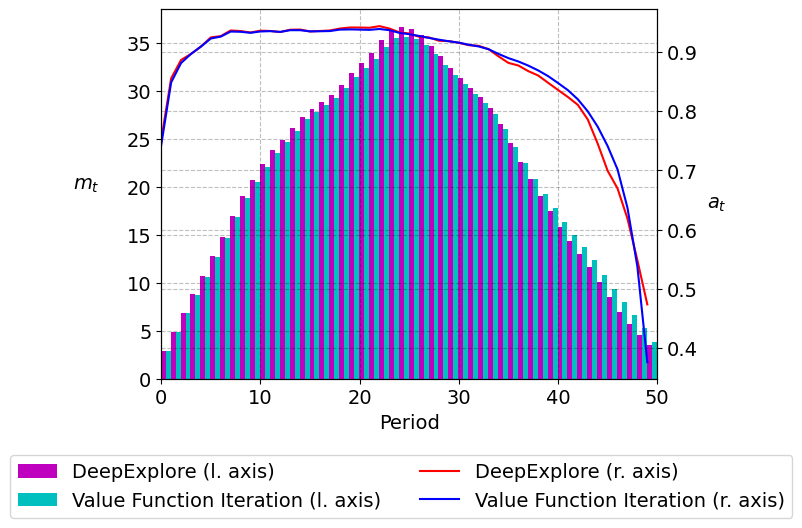

In [21]:
# 1. Choose agent
agent = 37031

# 2. Extract data
y1 = vfi_sim_action[:, agent]
x1 = vfi_sim_state[:, agent, 0]
y2 = de_baseline_low_lr_sim_action[:, agent].cpu().numpy()
x2 = de_baseline_low_lr_sim_state[:, agent, 0].cpu().numpy()

t_list = np.arange(len(y2))

# 4. Make fig and 2nd y-axis
f, ax1 = plt.subplots(1, 1)
ax2 = ax1.twinx()

# 5. Plot
ax1.bar(t_list + 0.2, x2, color='m', width=0.5, label='DeepExplore (l. axis)')
ax1.bar(t_list + 0.7, x1, color='c', width=0.5, label='Value Function Iteration (l. axis)')
ax2.plot(t_list, y2, color='r', label='DeepExplore (r. axis)')
ax2.plot(t_list, y1, color='b', label='Value Function Iteration (r. axis)')

# 5. Make pretty
ax1.set_xlabel('Period')
ax1.set_ylabel('$m_t$', rotation=0)
ax2.set_ylabel('$a_t$', rotation=0)
ax1.yaxis.set_label_coords(-0.15, 0.5)
ax2.yaxis.set_label_coords(1.12, 0.5)
ax1.set_xlim([0, 50])
f.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)

#plt.savefig('VFI_vs_DE_baseline_low_lr_Agent_9999_simulation.png')

## Spread of $m_t$

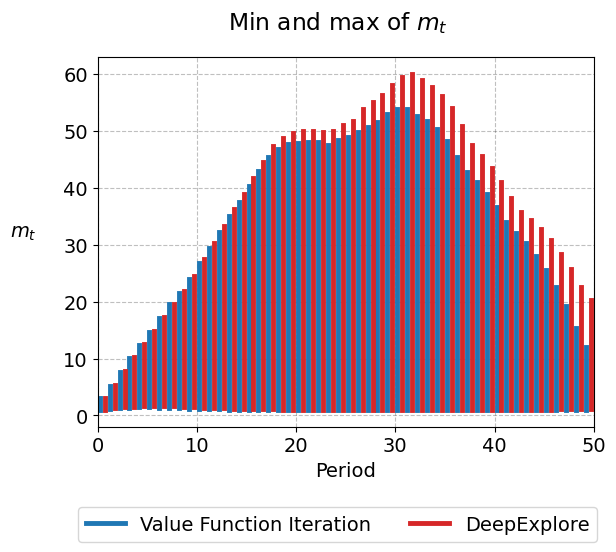

In [22]:
DE_array = de_baseline_low_lr_sim_state[:, :, 0].cpu().numpy()

# 2. Make lists 
VFI_max_list = []
VFI_min_list = []

DE_max_list = []
DE_min_list = []

periods = list(range(50))

for t in periods:

    vfi_period = vfi_sim_state[t, :, 0]
    de_period = DE_array[t]

    VFI_max_list.append(vfi_period.max())
    VFI_min_list.append(vfi_period.min())

    DE_max_list.append(de_period.max())
    DE_min_list.append(de_period.min())

# 3. Make plots
f, ax = plt.subplots(1, 1)

for i, (min_v, max_v) in enumerate(zip(VFI_min_list, VFI_max_list)):
    plt.plot([periods[i] + 0.2, periods[i] + 0.2], [min_v, max_v], color='tab:blue', lw=3.5, label='Value Function Iteration' if i == 0 else "")

for i, (min_v, max_v) in enumerate(zip(DE_min_list, DE_max_list)):
    plt.plot([periods[i] + 0.7, periods[i] + 0.7], [min_v, max_v], color='tab:red', lw=3.5, label='DeepExplore' if i == 0 else "")

ax.set_xlabel('Period')
ax.set_ylabel('$m_t$', rotation=0)
ax.set_xlim([0, 50])
ax.yaxis.set_label_coords(-0.15, 0.5)
f.suptitle('Min and max of $m_t$')
f.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=2)

## Euler Errors

DeepExplore baseline Euler Errors
log10 mean:	-2.13848
mean:		0.00727
----------------------------------------
DeepExplore differentiated learning Euler Errors
log10 mean:	-2.27475
mean		0.00531
----------------------------------------


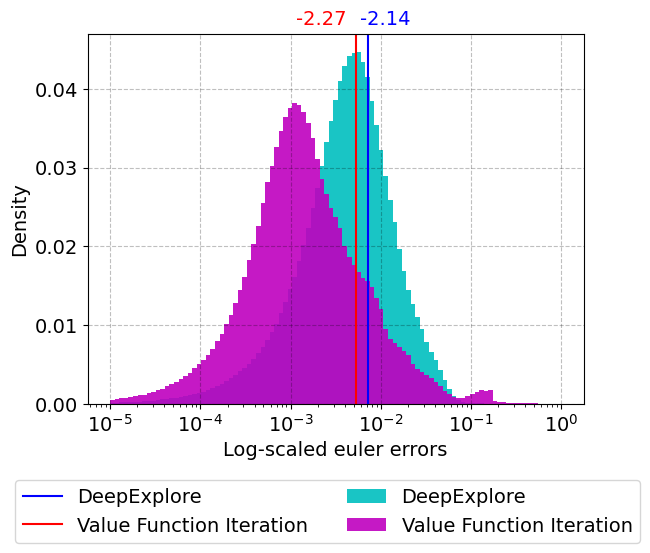

In [23]:
# 1. Convert tensors to arrays
de_ee = de_baseline_low_lr_ee.cpu().numpy()

# 1. Construct log-scaled bins
bins = 10**np.linspace(-5, 0, 100)

f, ax = plt.subplots(1, 1)

de_baseline, _ = np.histogram(de_ee, bins=bins)
vfi, _ = np.histogram(vfi_sim_ee, bins=bins)

de_baseline_dens = de_baseline / de_baseline.sum()
vfi_dens = vfi / vfi.sum()

ax.bar(bins[:-1], de_baseline_dens, width=np.diff(bins), alpha=0.9, align='edge', label='DeepExplore', color='c')
ax.bar(bins[:-1], vfi_dens, width=np.diff(bins), alpha=0.9, align='edge', label='Value Function Iteration', color='m')

# 4. Make it look pretty
ax.set_ylabel('Density')
ax.set_xlabel('Log-scaled euler errors')

# 5. Log-scale x-axis
plt.xscale("log")

# 6. Plot horizonetal mean-line
plt.axvline(x = np.mean(de_ee), ymin=0, ymax=1, color='b', label='DeepExplore')
plt.axvline(x = np.mean(vfi_sim_ee), ymin=0, ymax=1, color='r', label='Value Function Iteration')
print(f'DeepExplore baseline Euler Errors\nlog10 mean:\t{np.log10(np.mean(de_ee)):.5f}\nmean:\t\t{de_ee.mean():.5f}')
print(f'{"-"*40}')
print(f'DeepExplore differentiated learning Euler Errors\nlog10 mean:\t{np.log10(np.mean(vfi_sim_ee)):.5f}\nmean\t\t{vfi_sim_ee.mean():.5f}')
print(f'{"-"*40}')

f.text(0.55, 0.9, f'{np.log10(np.mean(de_ee)):.2f}', color='b')
f.text(0.45, 0.9, f'{np.log10(np.mean(vfi_sim_ee)):.2f}', color='r')

f.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)

## DeepExplore baseline vs. VFI (high lr = 0.0001)

### Time vs. Precision plot

In [24]:
# Import data
de_baseline_high_lr_nn = load_and_dump.load_nn('baseline', np.array([450, 450]))
de_baseline_high_lr_ee = load_and_dump.load_arrays('/results/tensors/de_baseline_high_lr_ee.pt', tensor=True, get_cwd=True)
de_baseline_high_lr_OSL = load_and_dump.load_arrays('/results/tensors/de_baseline_high_lr_OSL.pt', tensor=True, get_cwd=True)
de_baseline_high_lr_time = load_and_dump.load_arrays('/results/tensors/de_baseline_high_lr_time.pt', tensor=True, get_cwd=True)

de_baseline_high_lr_sim_state = load_and_dump.load_arrays('/results/tensors/de_baseline_high_lr_sim_state.pt', tensor=True, get_cwd=True)
de_baseline_high_lr_sim_action = load_and_dump.load_arrays('/results/tensors/de_baseline_high_lr_sim_action.pt', tensor=True, get_cwd=True)
de_baseline_high_lr_sim_obj = load_and_dump.load_arrays('/results/tensors/de_baseline_high_lr_sim_obj.pt', tensor=True, get_cwd=True)

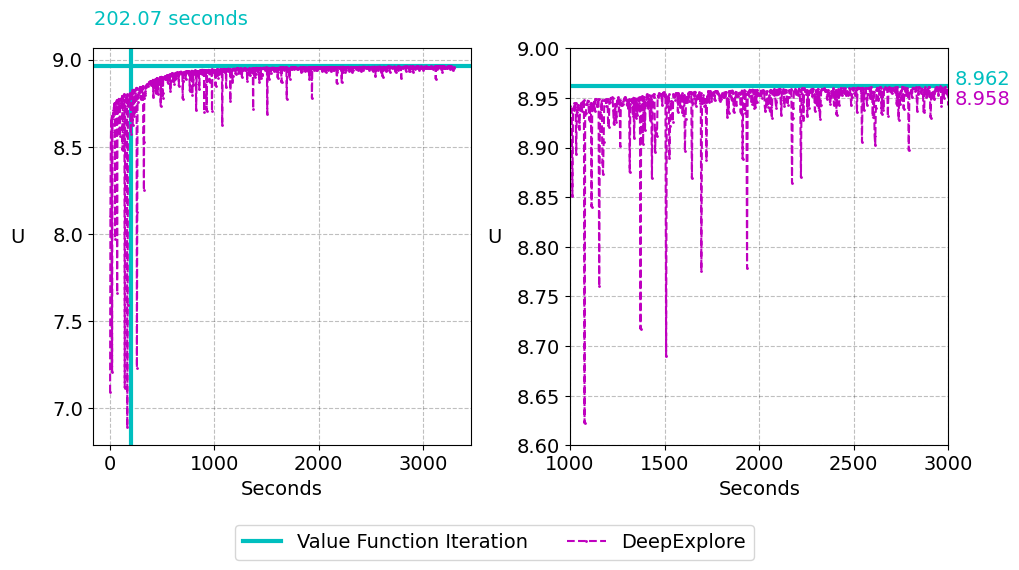

In [25]:
# 2. Plot
y = (-de_baseline_high_lr_OSL).tolist()
x = torch.cumsum(de_baseline_high_lr_time[:, -1], dim=0).tolist()
f, ax = plt.subplots(1,2, figsize=(10, 5))

# 2.1 1st plot
ax[0].axvline(vfi_time.sum(), label='Value Function Iteration', color='c', linewidth=3)
ax[0].axhline(vfi_sim_obj.mean(), color='c', linewidth=3)
ax[0].set_xlabel('Seconds')

ax[0].plot(x, y, linestyle='--', marker='o', markersize=1, color='m', label='DeepExplore')
ax[0].set_ylabel('U', rotation=0)
ax[0].yaxis.set_label_coords(-0.2, 0.5)

# 2.2 2nd plot
ax[1].axvline(vfi_time.sum(), color='c', linewidth=3)
ax[1].axhline(vfi_sim_obj.mean(), color='c', linewidth=3)
ax[1].set_xlabel('Seconds')
ax[1].plot(x, y, linestyle='--', marker='o', markersize=1, color='m')

ax[1].set_ylabel('U', rotation=0)
ax[1].yaxis.set_label_coords(-0.2, 0.5)
ax[1].set_xlim([1000,3000])
ax[1].set_ylim([8.6, 9])

# 2.3 Add text
f.text(0.1, 0.99, f'{vfi_time.sum():.2f} seconds', color='c')
f.text(0.96, 0.87, f'{vfi_sim_obj.mean():.3f}', color='c')
f.text(0.96, 0.83, f'{y[-1]:.3f}', color='m')

# 2.4 Make pretty
f.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2)
f.tight_layout()

### Policy, action, state

<>:24: SyntaxWarning: invalid escape sequence '\p'
<>:24: SyntaxWarning: invalid escape sequence '\p'
/var/folders/33/xqtwrk8s3ws6yhnm9qx48q2m0000gn/T/ipykernel_6495/3092539281.py:24: SyntaxWarning: invalid escape sequence '\p'
  ax[0].set_ylabel(f'$\pi_{{{period}}}$', rotation=0)


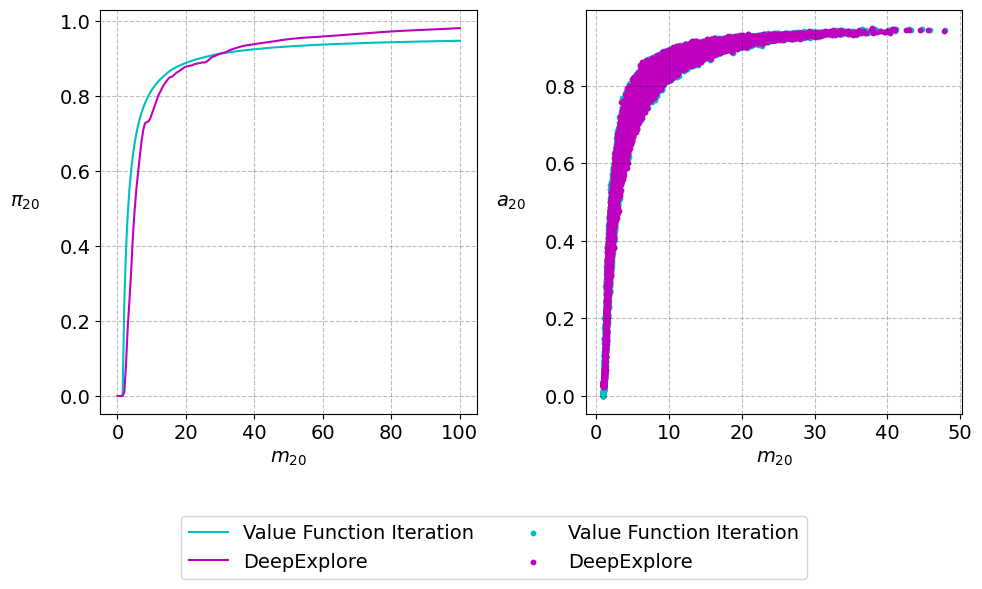

In [27]:
# 1. Choose period
period = 20

# 2. Extract policy function and policy network
vfi_m_grid = np.linspace(0, 100, 200)
vfi_R_grid = np.linspace(0.5, 1.5, 200)
vfi_p_grid = np.linspace(0, 5, 200)

nn_m_grid = torch.linspace(0, 100, 200)
nn_output = torch.zeros(200)

R = vfi_R_grid[100] # Same R value as in VFI
p = vfi_p_grid[100] # Same p value as in VFI

for i, m in enumerate(nn_m_grid):
    tensor = torch.tensor([m, R, p, period], dtype=torch.float32)
    nn_output[i] = de_baseline_high_lr_nn.forward(tensor)

# 3. Plot
f, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(vfi_m_grid[3:], vfi_policy_grid[period, 3:, 100, 100], label='Value Function Iteration', color='c')
ax[0].plot(nn_m_grid.cpu().numpy(), nn_output.detach(), label='DeepExplore', color='m')
ax[0].set_xlabel(f'$m_{{{period}}}$')
ax[0].set_ylabel(f'$\pi_{{{period}}}$', rotation=0)
ax[0].yaxis.set_label_coords(-0.2, 0.5)

ax[1].scatter(vfi_sim_state[period, :, 0], vfi_sim_action[period], alpha=1.0, color='c', label='Value Function Iteration', s=10)
ax[1].scatter(de_baseline_high_lr_sim_state[period, :, 0].cpu().numpy(), de_baseline_high_lr_sim_action[period].cpu().numpy(), alpha=1.0, color='m', label='DeepExplore', s=10)
ax[1].set_xlabel(f'$m_{{{period}}}$')
ax[1].set_ylabel(f'$a_{{{period}}}$', rotation=0)
ax[1].yaxis.set_label_coords(-0.2, 0.5)

# 4. Make pretty
f.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)
f.tight_layout()

### Lifecycle

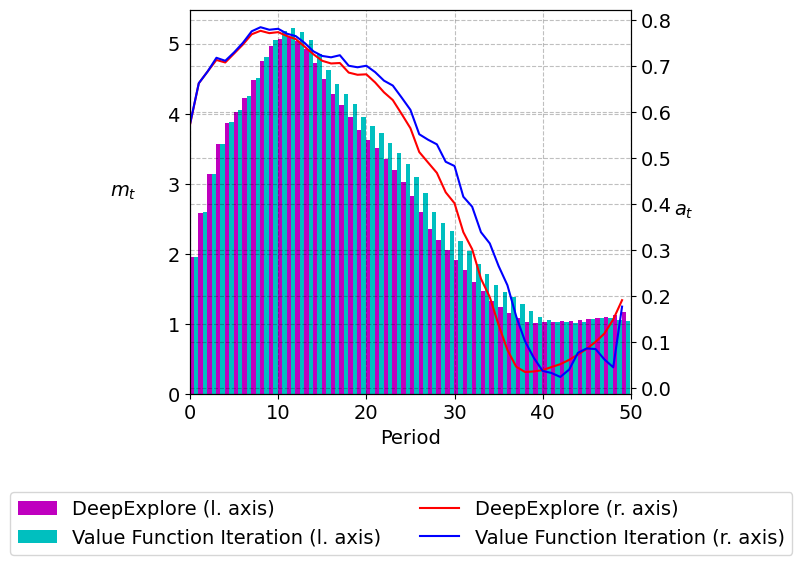

In [28]:
# 1. Choose agent
agent = 9999

# 2. Extract data
y1 = vfi_sim_action[:, agent]
x1 = vfi_sim_state[:, agent, 0]
y2 = de_baseline_high_lr_sim_action[:, agent].cpu().numpy()
x2 = de_baseline_high_lr_sim_state[:, agent, 0].cpu().numpy()

t_list = np.arange(len(y2))

# 4. Make fig and 2nd y-axis
f, ax1 = plt.subplots(1, 1)
ax2 = ax1.twinx()

# 5. Plot
ax1.bar(t_list + 0.2, x2, color='m', width=0.5, label='DeepExplore (l. axis)')
ax1.bar(t_list + 0.7, x1, color='c', width=0.5, label='Value Function Iteration (l. axis)')
ax2.plot(t_list, y2, color='r', label='DeepExplore (r. axis)')
ax2.plot(t_list, y1, color='b', label='Value Function Iteration (r. axis)')

# 5. Make pretty
ax1.set_xlabel('Period')
ax1.set_ylabel('$m_t$', rotation=0)
ax2.set_ylabel('$a_t$', rotation=0)
ax1.yaxis.set_label_coords(-0.15, 0.5)
ax2.yaxis.set_label_coords(1.12, 0.5)
ax1.set_xlim([0, 50])
f.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)

f.tight_layout()

### Euler Errors

DeepExplore baseline Euler Errors
log10 mean:	-2.21106
mean:		0.00615
----------------------------------------
DeepExplore differentiated learning Euler Errors
log10 mean:	-2.27475
mean		0.00531
----------------------------------------


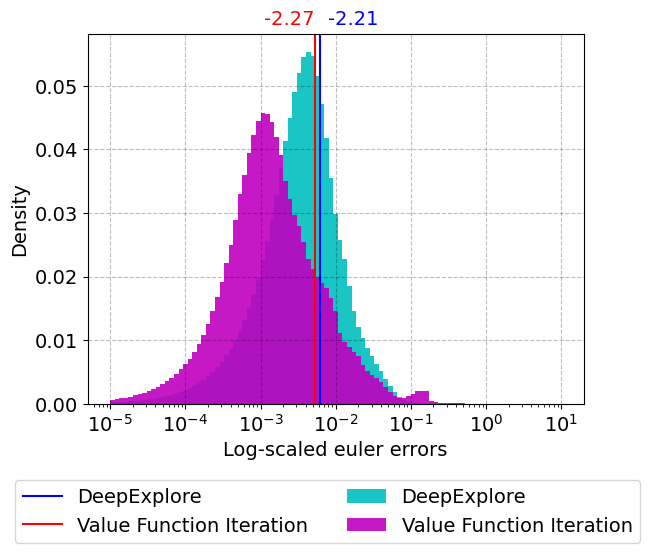

In [29]:
# 1. Convert tensors to arrays
de_baseline_euler_errors_array = de_baseline_high_lr_ee.cpu().numpy()

# 1. Construct log-scaled bins
bins = 10**np.linspace(-5, 1, 100)

f, ax = plt.subplots(1, 1)

de_baseline, _ = np.histogram(de_baseline_euler_errors_array, bins=bins)
vfi, _ = np.histogram(vfi_sim_ee, bins=bins)

de_baseline_dens = de_baseline / de_baseline.sum()
vfi_dens = vfi / vfi.sum()

ax.bar(bins[:-1], de_baseline_dens, width=np.diff(bins), alpha=0.9, align='edge', label='DeepExplore', color='c')
ax.bar(bins[:-1], vfi_dens, width=np.diff(bins), alpha=0.9, align='edge', label='Value Function Iteration', color='m')

# 4. Make it look pretty
ax.set_ylabel('Density')
ax.set_xlabel('Log-scaled euler errors')

# 5. Log-scale x-axis
plt.xscale("log")

# 6. Plot horizonetal mean-line
plt.axvline(x = np.mean(de_baseline_euler_errors_array), ymin=0, ymax=1, color='b', label='DeepExplore')
plt.axvline(x = np.mean(vfi_sim_ee), ymin=0, ymax=1, color='r', label='Value Function Iteration')
print(f'DeepExplore baseline Euler Errors\nlog10 mean:\t{np.log10(np.mean(de_baseline_euler_errors_array)):.5f}\nmean:\t\t{de_baseline_euler_errors_array.mean():.5f}')
print(f'{"-"*40}')
print(f'DeepExplore differentiated learning Euler Errors\nlog10 mean:\t{np.log10(np.mean(vfi_sim_ee)):.5f}\nmean\t\t{vfi_sim_ee.mean():.5f}')
print(f'{"-"*40}')

f.text(0.5, 0.9, f'{np.log10(np.mean(de_baseline_euler_errors_array)):.2f}', color='b')
f.text(0.4, 0.9, f'{np.log10(np.mean(vfi_sim_ee)):.2f}', color='r')

f.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)

# Differentiated learning

### Time vs precision plot
### Euler Errors

In [30]:
de_dif_lr_nn = load_and_dump.load_nn('dif_lr_836', np.array([450, 450]))
de_dif_lr_ee = load_and_dump.load_arrays('/results/tensors/de_dif_lr_ee_836.pt', tensor=True, get_cwd=True)
de_dif_lr_OSL = load_and_dump.load_arrays('/results/tensors/de_dif_lr_OSL_836.pt', tensor=True, get_cwd=True)
de_dif_lr_time = load_and_dump.load_arrays('/results/tensors/de_dif_lr_time_836.pt', tensor=True, get_cwd=True)

# (0, 0.001), (99, 0.0001), (499, 0.00005), (799, 0.00001)

DeepExplore baseline Euler Errors
log10 mean:	-2.13848
mean:		0.00727
----------------------------------------
DeepExplore differentiated learning Euler Errors
log10 mean:	-1.68965
mean		0.02043
----------------------------------------


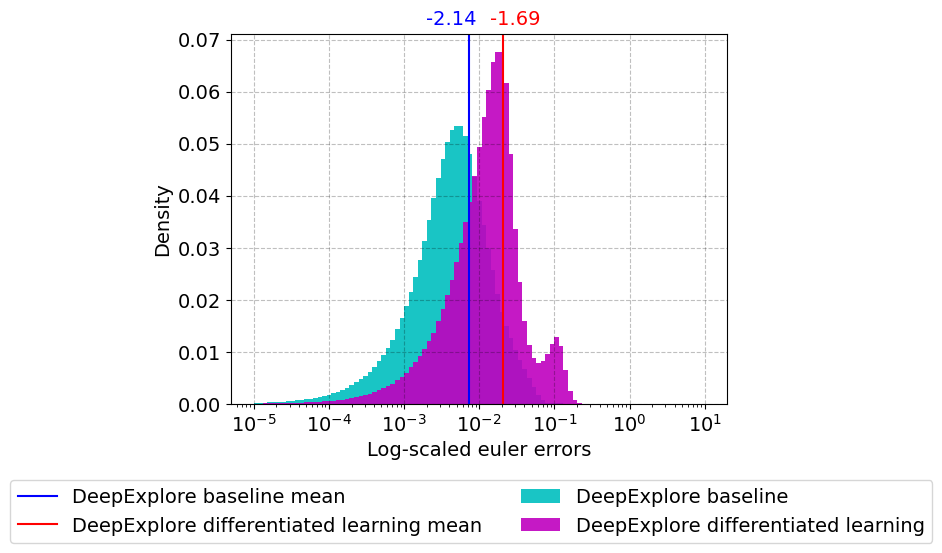

In [36]:
de_dif_lr_euler_errors_array = de_dif_lr_ee.cpu().numpy().flatten()
de_baseline_euler_errors_array = de_baseline_low_lr_ee.cpu().numpy().flatten()

# 1. Construct log-scaled bins
bins = 10**np.linspace(-5, 1, 100)

f, ax = plt.subplots(1, 1)

de_baseline, _ = np.histogram(de_baseline_euler_errors_array, bins=bins)
de_dif, _ = np.histogram(de_dif_lr_euler_errors_array, bins=bins)

de_baseline_dens = de_baseline / de_baseline.sum()
de_dif_dens = de_dif / de_dif.sum()

ax.bar(bins[:-1], de_baseline_dens, width=np.diff(bins), alpha=0.9, align='edge', label='DeepExplore baseline', color='c')
ax.bar(bins[:-1], de_dif_dens, width=np.diff(bins), alpha=0.9, align='edge', label='DeepExplore differentiated learning', color='m')

# 4. Make it look pretty
ax.set_ylabel('Density')
ax.set_xlabel('Log-scaled euler errors')

# 5. Log-scale x-axis
plt.xscale("log")

# 6. Plot horizonetal mean-line
plt.axvline(x = np.mean(de_baseline_euler_errors_array), ymin=0, ymax=1, color='b', label='DeepExplore baseline mean')
plt.axvline(x = np.mean(de_dif_lr_euler_errors_array), ymin=0, ymax=1, color='r', label='DeepExplore differentiated learning mean')
print(f'DeepExplore baseline Euler Errors\nlog10 mean:\t{np.log10(np.mean(de_baseline_euler_errors_array)):.5f}\nmean:\t\t{de_baseline_euler_errors_array.mean():.5f}')
print(f'{"-"*40}')
print(f'DeepExplore differentiated learning Euler Errors\nlog10 mean:\t{np.log10(np.mean(de_dif_lr_euler_errors_array)):.5f}\nmean\t\t{de_dif_lr_euler_errors_array.mean():.5f}')
print(f'{"-"*40}')

f.text(0.43, 0.9, f'{np.log10(np.mean(de_baseline_euler_errors_array)):.2f}', color='b')
f.text(0.53, 0.9, f'{np.log10(np.mean(de_dif_lr_euler_errors_array)):.2f}', color='r')

f.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)

<>:24: SyntaxWarning: invalid escape sequence '\e'
<>:25: SyntaxWarning: invalid escape sequence '\e'
<>:26: SyntaxWarning: invalid escape sequence '\e'
<>:24: SyntaxWarning: invalid escape sequence '\e'
<>:25: SyntaxWarning: invalid escape sequence '\e'
<>:26: SyntaxWarning: invalid escape sequence '\e'
/var/folders/33/xqtwrk8s3ws6yhnm9qx48q2m0000gn/T/ipykernel_6495/2428238617.py:24: SyntaxWarning: invalid escape sequence '\e'
  ax[0].axvline(changeone, color='tab:blue', linewidth=1, linestyle='--',  label='$\eta=0.0001$')
/var/folders/33/xqtwrk8s3ws6yhnm9qx48q2m0000gn/T/ipykernel_6495/2428238617.py:25: SyntaxWarning: invalid escape sequence '\e'
  ax[0].axvline(changetwo, color='tab:red', linewidth=1, linestyle='--', label='$\eta=0.00005$')
/var/folders/33/xqtwrk8s3ws6yhnm9qx48q2m0000gn/T/ipykernel_6495/2428238617.py:26: SyntaxWarning: invalid escape sequence '\e'
  ax[0].axvline(changethree, color='tab:green', linewidth=1, linestyle='--', label='$\eta=0.00001$')


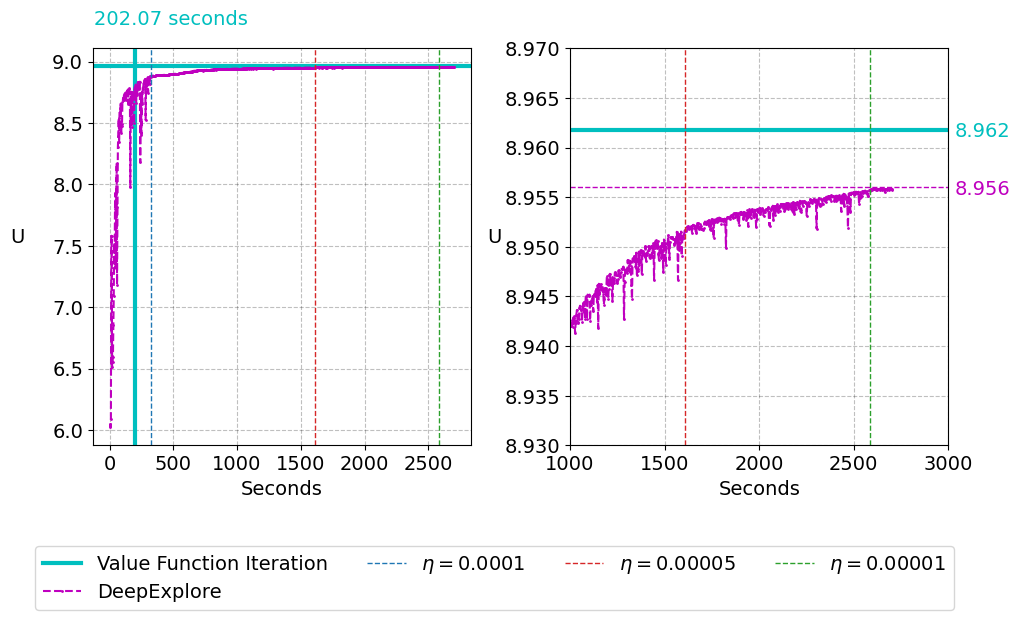

In [37]:
# 1. Data
de_dif_lr1_comp_time_shapelist = torch.cumsum(de_dif_lr_time[:, -1], dim=0).tolist()[:836]
de_dif_lr1_out_of_sample_evals_list = (-de_dif_lr_OSL).tolist()[:836]

changeone = de_dif_lr1_comp_time_shapelist[99]
changetwo = de_dif_lr1_comp_time_shapelist[499]
changethree = de_dif_lr1_comp_time_shapelist[799]

vfi_obj = vfi_sim_obj.mean()

# 2. Plot
f, ax = plt.subplots(1,2, figsize=(10, 5))

# 2.1 1st plot
ax[0].axvline(vfi_time.sum(), label='Value Function Iteration', color='c', linewidth=3)
ax[0].axhline(vfi_obj, color='c', linewidth=3)
ax[0].set_xlabel('Seconds')

ax[0].plot(de_dif_lr1_comp_time_shapelist, de_dif_lr1_out_of_sample_evals_list, linestyle='--', marker='o', markersize=1, color='m', label='DeepExplore')
ax[0].set_ylabel('U', rotation=0)
ax[0].yaxis.set_label_coords(-0.2, 0.5)

# Plot changes in lr
ax[0].axvline(changeone, color='tab:blue', linewidth=1, linestyle='--',  label='$\eta=0.0001$')
ax[0].axvline(changetwo, color='tab:red', linewidth=1, linestyle='--', label='$\eta=0.00005$')
ax[0].axvline(changethree, color='tab:green', linewidth=1, linestyle='--', label='$\eta=0.00001$')

# changes happens corresponding to [(0, 0.001), (99, 0.0001), (499, 0.00005), (799, 0.00001)]

# 2.2 2nd plot
ax[1].axvline(vfi_time.sum(), color='c', linewidth=3)
ax[1].axhline(vfi_obj, color='c', linewidth=3)
ax[1].set_xlabel('Seconds')
ax[1].plot(de_dif_lr1_comp_time_shapelist, de_dif_lr1_out_of_sample_evals_list, linestyle='--', marker='o', markersize=1, color='m')

ax[1].set_ylabel('U', rotation=0)
ax[1].yaxis.set_label_coords(-0.2, 0.5)
ax[1].set_xlim([1000,3000])
ax[1].set_ylim([8.93, 8.97])

f.text(0.1, 0.99, f'{vfi_time.sum():.2f} seconds', color='c')

f.text(0.96, 0.765, f'{vfi_obj:.3f}', color='c')

f.text(0.96, 0.65, f'{de_dif_lr1_out_of_sample_evals_list[-1]:.3f}', color='m')
ax[1].axhline(de_dif_lr1_out_of_sample_evals_list[-1]+0.0003, color='m', linewidth=1, linestyle='--')
ax[1].axvline(changetwo, color='tab:red', linewidth=1, linestyle='--')
ax[1].axvline(changethree, color='tab:green', linewidth=1, linestyle='--')

f.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=4)
f.tight_layout()

# Different number neurons

### euler errors

In [38]:
# 1. Load tensors with euler errors
name_list = ['150', '150_150', '150_150_150', '300', '300_300', '300_300_300', '450', '450_450', '450_450_450', '600', '600_600', '600_600_600']

tensor_ee_dict = {}
tensor_ee_dict_means = {}

for name in name_list:
    if name == '150_150_150':
        array_path = '/results/tensors/neuron_' + name + '_ee_987.pt'

    else:
        array_path = '/results/tensors/neuron_' + name + '_ee.pt'
    
    tensor_ee = load_and_dump.load_arrays(array_path, tensor=True, get_cwd=True)

    tensor_ee_dict[name] = tensor_ee

    tensor_ee_dict_means[name] = tensor_ee.mean()

/Users/mikkelrich/Desktop/Final files/shared_modules/load_and_dump.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(array_path)


### Best out-of-sample evaluation iteration loss

In [39]:
# 2. Load tensors with out_of_sample_evals

name_list = ['150', '150_150', '150_150_150', '300', '300_300', '300_300_300', '450', '450_450', '450_450_450', '600', '600_600', '600_600_600']

tensor_out_of_sample_dict = {}
tensor_out_of_sample_dict_best_eval = {}

for name in name_list:
    if name == '150_150_150':
        array_path = '/results/tensors/neuron_' + name + '_OSL_987.pt'

    else:
        array_path = '/results/tensors/neuron_' + name + '_OSL.pt'
    
    tensor_out_sample_eval = load_and_dump.load_arrays(array_path, tensor=True, get_cwd=True)

    tensor_out_of_sample_dict[name] = tensor_out_sample_eval

    tensor_out_of_sample_dict_best_eval[name] = tensor_out_sample_eval.min()

### Euler errors and best evaluation for different number of neurons

In [54]:
print(tensor_out_of_sample_dict_best_eval)
print(tensor_ee_dict_means)

{'150': tensor(-8.8555), '150_150': tensor(-8.9346), '150_150_150': tensor(-8.9533), '300': tensor(-8.8923), '300_300': tensor(-8.9440), '300_300_300': tensor(-8.9597), '450': tensor(-8.9028), '450_450': tensor(-8.9523), '450_450_450': tensor(-8.9587), '600': tensor(-8.9148), '600_600': tensor(-8.9528), '600_600_600': tensor(-8.9620)}
{'150': tensor(0.0127), '150_150': tensor(0.0103), '150_150_150': tensor(0.0089), '300': tensor(0.0110), '300_300': tensor(0.0089), '300_300_300': tensor(0.0072), '450': tensor(0.0101), '450_450': tensor(0.0073), '450_450_450': tensor(0.0069), '600': tensor(0.0096), '600_600': tensor(0.0073), '600_600_600': tensor(0.0056)}
